# ДЗ ARMA

In [18]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
from arch import arch_model

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [22]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

# Грузим данные из прошлого дз

In [25]:

series_exchange_rate = pd.read_csv("exchange-rate-twi-may-1970-aug-1.csv", names= ['Month', 'Rate'], header=0)
series_exchange_rate.dropna(inplace=True)
series_exchange_rate = series_exchange_rate.Rate

series_melanoma = pd.read_csv("annual-male-melanoma-incidence-a.csv", names= ['Year', 'Count'], header=0)
series_melanoma.dropna(inplace=True)
series_melanoma = series_melanoma.Count

##  Строим ARIMA (p,d,q) для рядов

In [67]:
# Подбор параметров и отрисовка графика остатков
def arima_model (series):

    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue


    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


    tsplot(best_mdl.resid, lags=30)
    return best_order


In [108]:
# Рисуем прогноз ARIMA на лучших параметрах, обучаем GARCH и рисуем остатки после GARCH
def print_arima_garch(series):
    
    best_order = arima_model(series.values)
    best_model = smt.ARIMA(series.values, order=best_order).fit(method='mle', trend='nc')
    with plt.style.context('bmh'):
        plt.figure(figsize=(14,8))
        ax = plt.axes()
        best_model.plot_predict(best_order[1], len(series)+20, ax=ax)
        plt.plot(series, color='red', label='Series')
        plt.legend()
        plt.show()
    p_ = best_order[0]
    o_ = best_order[1]
    q_ = best_order[2]
    
    
    
    am = arch_model(new_series, p=p_, o=o_, q=q_, dist='StudentsT')
    res = am.fit(update_freq=5)
    print(res.summary())
    tsplot(res.resid)

C:\Users\Python\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Python\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\Python\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
C:\Users\Python\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\Users\Python\Anaconda3\lib\site-packages\statsmodels\tsa\tsat

aic: 1321.56375 | order: (3, 1, 2)


C:\Users\Python\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Results of Dickey-Fuller Test:
Test Statistic                -1.729735e+01
p-value                        5.656371e-30
#Lags Used                     0.000000e+00
Number of Observations Used    3.020000e+02
Critical Value (1%)           -3.452190e+00
Critical Value (5%)           -2.871158e+00
Critical Value (10%)          -2.571895e+00
dtype: float64


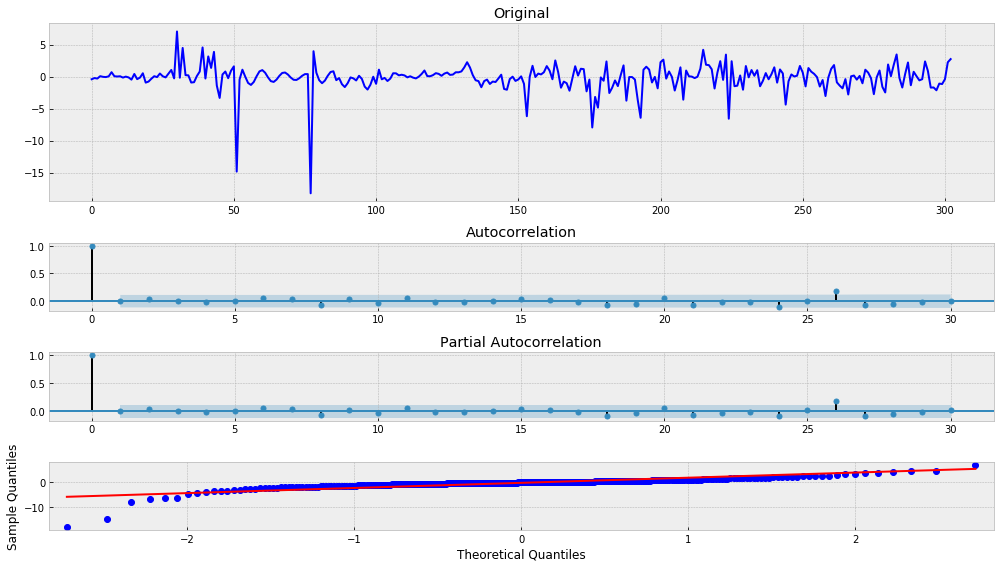

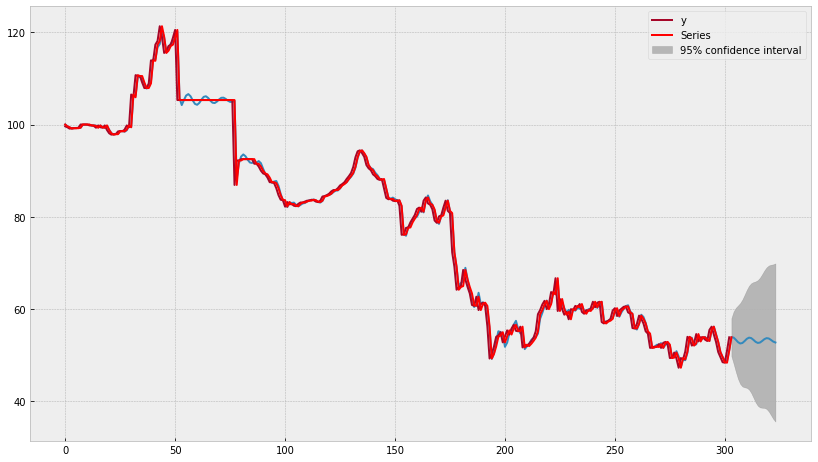

Iteration:      5,   Func. Count:     75,   Neg. LLF: 169.74031688104293
Iteration:     10,   Func. Count:    154,   Neg. LLF: 663.4273008061892
Iteration:     15,   Func. Count:    226,   Neg. LLF: -549.9875228913313
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -571.2698688349565
            Iterations: 21
            Function evaluations: 259
            Gradient evaluations: 17


C:\Users\Python\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                      -0.052
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.052
Vol Model:                        GJR-GARCH   Log-Likelihood:                571.270
Distribution:      Standardized Student's t   AIC:                          -1124.54
Method:                  Maximum Likelihood   BIC:                          -1091.12
                                              No. Observations:                  303
Date:                      Mon, Aug 06 2018   Df Residuals:                      294
Time:                              14:51:09   Df Model:                            9
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

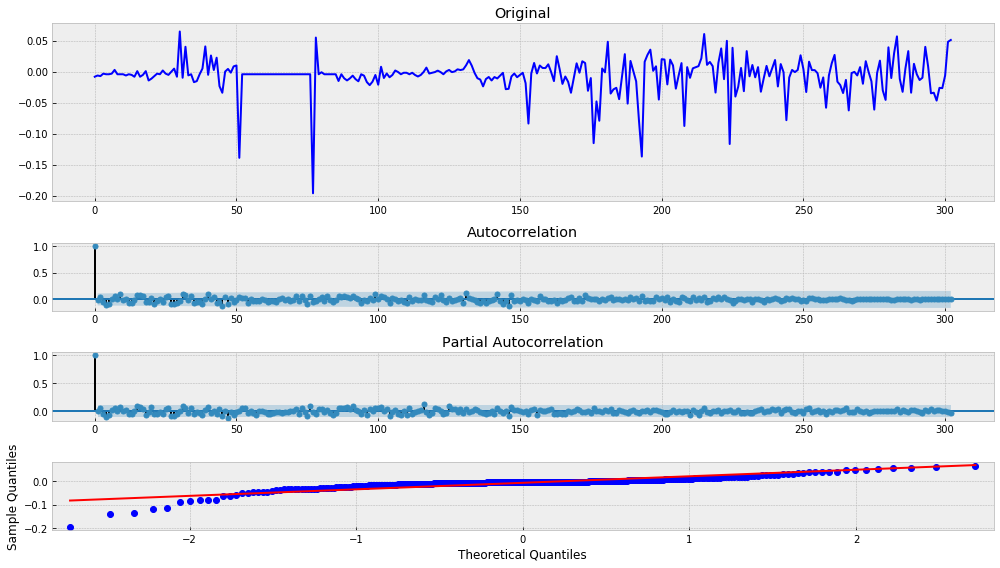

In [95]:
print_arima_garch(series_exchange_rate)

C:\Users\Python\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Python\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

aic: 53.27928 | order: (1, 2, 4)


C:\Users\Python\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Results of Dickey-Fuller Test:
Test Statistic                -6.170930e+00
p-value                        6.808336e-08
#Lags Used                     0.000000e+00
Number of Observations Used    3.400000e+01
Critical Value (1%)           -3.639224e+00
Critical Value (5%)           -2.951230e+00
Critical Value (10%)          -2.614447e+00
dtype: float64


C:\Users\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


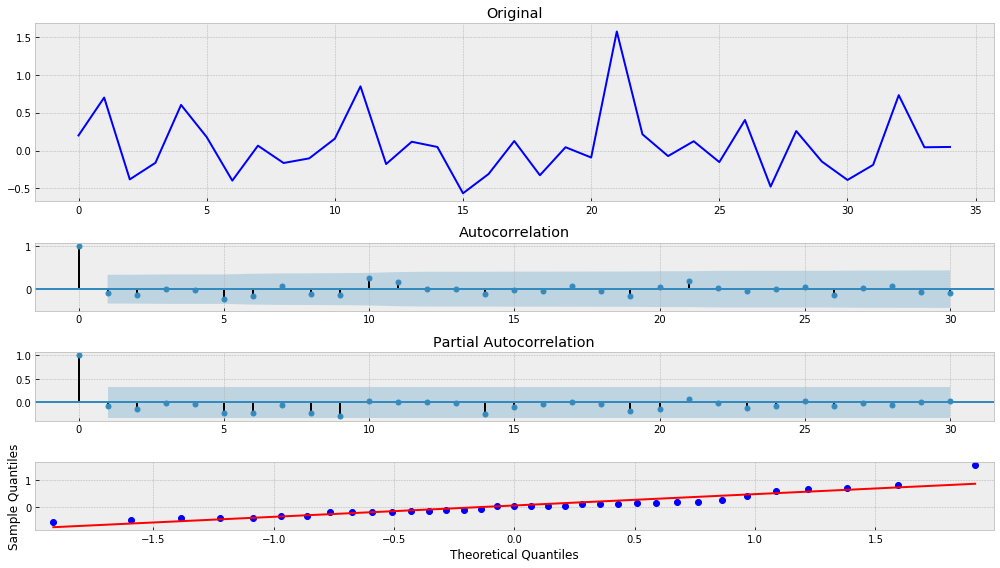

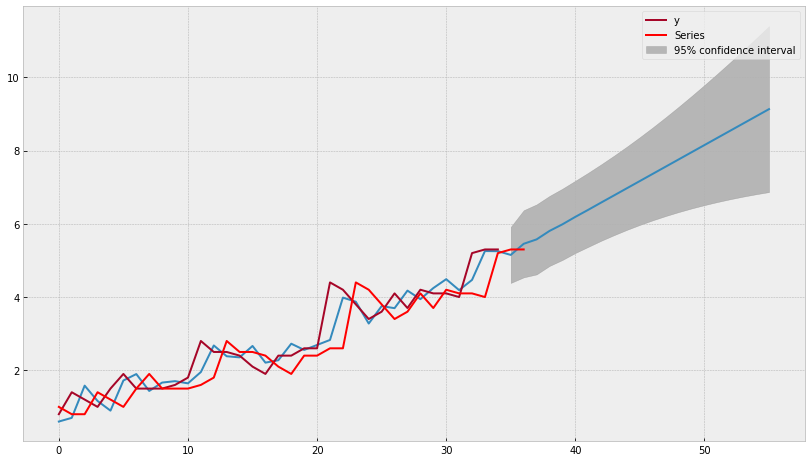

Iteration:      5,   Func. Count:     64,   Neg. LLF: 56.1650262381184
Iteration:     10,   Func. Count:    129,   Neg. LLF: 55.56545275938859
Iteration:     15,   Func. Count:    189,   Neg. LLF: 55.462619539033554
Iteration:     20,   Func. Count:    249,   Neg. LLF: 55.38685290981666
Iteration:     25,   Func. Count:    309,   Neg. LLF: 55.24108541703256
Iteration:     30,   Func. Count:    369,   Neg. LLF: 55.19804568685073
Iteration:     35,   Func. Count:    435,   Neg. LLF: 55.18974318748581
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 55.1897431913519
            Iterations: 35
            Function evaluations: 446
            Gradient evaluations: 35
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                      -0.350
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.350
Vol Model:                     

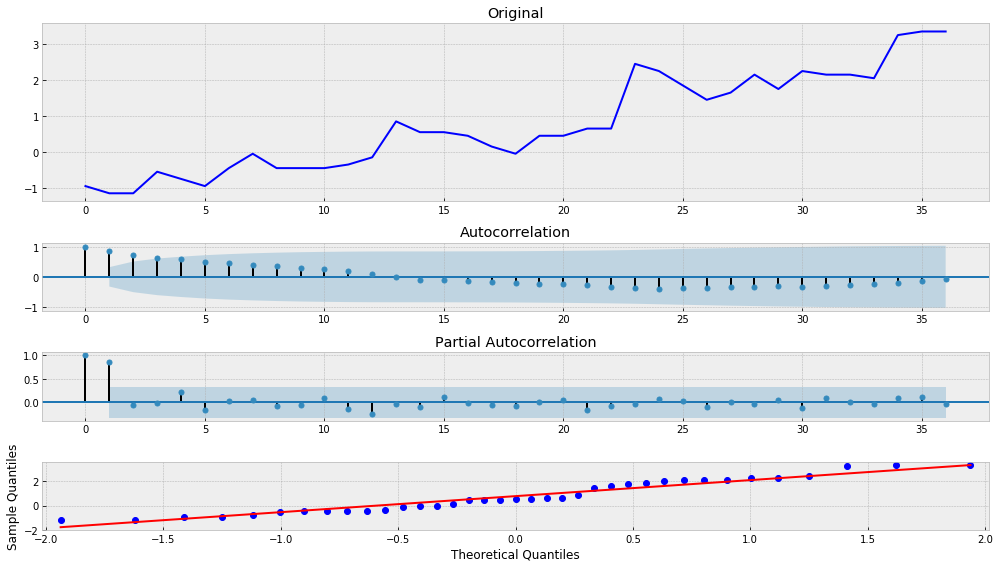

In [96]:
print_arima(series_melanoma)

# Выводы: ну оба ряда хорошо описались моделями ARIMA. Остатки получились "хорошие" нормально распределенные График прогноза хорошо описывает поведения ряда. А вот с GARCH я не понял: первый ряд вроде получил примерно те же остатки. А второй совсем плох. Может быть надо было его дифференцировать и box cox сделать перед тем как пихать в GARCH

## не понял как делать прогноз классическим способом. В данных у нас есть только один предиктор и один лейбл. Построить линейную регрессию - это значит построить прямую, что врятли хорошо опишет наш ряд